In [11]:
import glob
import os
import collections

import pickle
import sys
import glob
from pathlib import Path, PurePath
path = Path.cwd()
parent_path = path.parents[1]
sys.path.append(str(PurePath(parent_path, 'neuroformer')))
sys.path.append('neuroformer')
sys.path.append('.')
sys.path.append('../')


import pandas as pd
import numpy as np
from einops import rearrange

from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
import pandas as pd
from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from trainer import Trainer, TrainerConfig
from utils import set_seed


from scipy import io as scipyio
from scipy.special import softmax
import skimage
import skvideo.io
from utils import print_full
from scipy.ndimage import gaussian_filter, uniform_filter


import matplotlib.pyplot as plt
from utils import *
from visualize import *
set_plot_params()
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"


from model_neuroformer import GPT, GPTConfig, neuralGPTConfig
from trainer import Trainer, TrainerConfig


import json


In [12]:
data_dir = "./data/VisNav_VR_Expt"

if not os.path.exists(data_dir):
    print("Downloading data...")
    import gdown
    url = "https://drive.google.com/drive/folders/117S-7NmbgrqjmjZ4QTNgoa-mx8R_yUso?usp=sharing"
    gdown.download_folder(id=url, quiet=False, use_cookies=False, output="data/")


In [13]:
# load config files
import yaml

base_path = "./configs/visnav"

with open(os.path.join(base_path, 'mconf.yaml'), 'r') as stream:
    mconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'tconf.yaml'), 'r') as stream:
    tconf = yaml.full_load(stream)

with open(os.path.join(base_path, 'dconf.yaml'), 'r') as stream:
    dconf = yaml.full_load(stream)

import omegaconf
from omegaconf import OmegaConf

# open yaml as omegacong
mconf = OmegaConf.create(mconf)
tconf = OmegaConf.create(tconf)
dconf = OmegaConf.create(dconf)



In [14]:
import mat73
import scipy

data_path = "data/VisNav_VR_Expt/experiment_data.mat"
data = mat73.loadmat(data_path)['neuroformer']

# data_response_path = "/data5/antonis/neuroformer/data/VisNav_VR_Expt/yiyi/experiment_data_selected.mat"
# data_response = scipy.io.loadmat(data_response_path)
neurons_sel2 = "./data/VisNav_VR_Expt/yiyi/sel2.csv"
neurons_sel2 = pd.read_csv(neurons_sel2)
neurons_sel2 = np.array(neurons_sel2).flatten()
print(data.keys())


dict_keys(['eyerad', 'phi', 'speed', 'spiketimes', 't', 'th', 'trialsummary', 'vid_sm'])


In [15]:
from SpikeVidUtils import trial_df, get_df_visnav

stimulus = data['vid_sm']
response = data['spiketimes']['spks']
trial_data = data['trialsummary']

print(data.keys())

df = get_df_visnav(response, trial_data)
df = df[df['ID'].isin(neurons_sel2)].reset_index(drop=True)

behavior_vars = ['t', 'speed']        # ['t', 'eyerad', 'phi', 'speed', 'th']
behavior = pd.DataFrame({k: data[k] for k in behavior_vars})

# rename t to time
behavior = behavior.rename(columns={'t': 'Time'})


dict_keys(['eyerad', 'phi', 'speed', 'spiketimes', 't', 'th', 'trialsummary', 'vid_sm'])


In [16]:
frame_window = 0.2
window = 0.05
window_prev = 0.2
window_behavior = window
dt = 0.005
dt_frames = 0.05
dt_vars = 0.05
intervals = None

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
df['real_interval'] = make_intervals(df, 0.05)
df['Interval_2'] = make_intervals(df, window_prev)
df = df.reset_index(drop=True)
behavior['Interval'] = make_intervals(behavior, window)
behavior['Interval_2'] = make_intervals(behavior, window_prev)

# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
max_window = max(window, window_prev)
dt_range = math.ceil(max_window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)] + ['EOS'] + ['PAD']


In [17]:
# int_trials = df.groupby(['Interval', 'Trial']).size()
# print(int_trials.mean())
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
var_group = 'Interval_2'
n_unique = len(df.groupby([var_group, 'Trial']).size())
# df.groupby([var_group, 'Trial']).size().nlargest(int(0.2 * n_unique))
df.groupby([var_group, 'Trial']).size().sort_values(ascending=False).nlargest(int(0.05 * n_unique))


Interval_2  Trial
2.8         62       83
1.2         268      81
11.2        246      79
5.0         107      77
3.6         80       72
                     ..
0.6         153      27
3.4         285      27
4.8         296      27
1.2         284      27
4.8         276      27
Length: 411, dtype: int64

In [18]:
from SpikeVidUtils import SpikeTimeVidData2

## resnet3d feats
n_frames = round(frame_window * 1/dt_frames)
kernel_size = (n_frames, 5, 5)
n_embd = 256
n_embd_frames = 64
frame_feats = None

frame_block_size = ((n_frames // kernel_size[0] * 30 * 100) // (n_embd_frames))
frame_feats = torch.tensor(stimulus, dtype=torch.float32)
conv_layer = True

assert (window_behavior) % dt_vars < 1e-5, "window + window_prev must be divisible by dt_vars"
samples_per_behavior = int((window + window_prev) // dt_vars)
behavior_block_size = int((window + window_prev) // dt_vars) * (len(behavior.columns) - 1)

prev_id_block_size = 300
id_block_size = 100   #
block_size = frame_block_size + id_block_size + prev_id_block_size
frame_memory = frame_window // dt_frames
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

neurons = sorted(list(set(df['ID'].unique())))
trial_tokens = [f"Trial {n}" for n in df['Trial'].unique()]
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }


In [19]:
import random

r_split = 0.8
all_trials = sorted(df['Trial'].unique())
train_trials = random.sample(all_trials, int(len(all_trials) * r_split))

train_data = df[df['Trial'].isin(train_trials)]
test_data = df[~df['Trial'].isin(train_trials)]


In [20]:
from SpikeVidUtils import SpikeTimeVidData2


train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset='visnav',
                                  behavior=behavior, dt_vars=dt_vars, 
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset='visnav',
                                  behavior=behavior, dt_vars=dt_vars, 
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior)

print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')



Length: 78746 Neurons: 263
id block size: 100
frames: 46, id: 100
Length: 16844 Neurons: 263
id block size: 100
frames: 46, id: 100
train: 22210, test: 5005


In [21]:
loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
iterable = iter(loader)


In [22]:
x, y = next(iterable)
# print(x['behavior'].shape, x['behavior_dt'].shape)
for k in x.keys():
    print(k, x[k].shape)


id_prev torch.Size([32, 300])
dt_prev torch.Size([32, 300])
pad_prev torch.Size([32])
id torch.Size([32, 100])
dt torch.Size([32, 100])
pad torch.Size([32])
interval torch.Size([32])
trial torch.Size([32])
behavior torch.Size([32, 3, 4, 1])
behavior_dt torch.Size([32, 4])
frames torch.Size([32, 1, 4, 30, 100])
cid torch.Size([32, 2])
pid torch.Size([32, 2])
f_idx torch.Size([32, 2])


In [23]:
from model_neuroformer import GPT, GPTConfig

layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)   
max_epochs = 100
batch_size = round((32 * 7))
shuffle = True

title =  f'window:{window}_prev:{window_prev}_chunks'

model_path = f"""./models/tensorboard/visnav/trials/speed-only_sell_2/all_vars/{title}/sparse_f:{mconf.sparse_topk_frame}_id:{mconf.sparse_topk_id}/w:{window}_wp:{window_prev}/{6}_Cont:{mconf.contrastive}_window:{window}_f_window:{frame_window}_df:{dt}_blocksize:{id_block_size}_conv_{conv_layer}_shuffle:{shuffle}_batch:{batch_size}_sparse_({mconf.sparse_topk_frame}_{mconf.sparse_topk_id})_blocksz{block_size}_pos_emb:{mconf.pos_emb}_temp_emb:{mconf.temp_emb}_drop:{mconf.id_drop}_dt:{shuffle}_2.0_{max(stoi_dt.values())}_max{dt}_{layers}_{mconf.n_head}_{mconf.n_embd}.pt"""

model_conf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        behavior_block_size=behavior_block_size,
                        sparse_mask=False, p_sparse=None, 
                        sparse_topk_frame=None, sparse_topk_id=None, sparse_topk_prev_id=None,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=None,
                        pretrain=False,
                        n_state_layers=mconf.n_state_layers, n_state_history_layers=mconf.n_state_history_layers,
                        n_stimulus_layers=0, self_att_layers=mconf.self_att_layers,
                        n_behavior_layers=mconf.n_behavior_layers,
                        n_head=mconf.n_head, n_embd=mconf.n_embd, 
                        contrastive=True, clip_emb=1024, clip_temp=0.5,
                        conv_layer=conv_layer, kernel_size=kernel_size,
                        temp_emb=True, pos_emb=False,
                        id_drop=0.35, im_drop=0.35, b_drop=0.45,
                        window=window, window_prev=window_prev, frame_window=frame_window, dt=dt,
                        neurons=neurons, stoi_dt=stoi_dt, itos_dt=itos_dt, n_embd_frames=n_embd_frames,
                        ignore_index_id=stoi['PAD'], ignore_index_dt=stoi_dt['PAD'])  # 0.35

model = GPT(model_conf)


11776
256 43


In [24]:
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=1e-4, 
                    num_workers=4, lr_decay=False, patience=3, warmup_tokens=8e7, 
                    decay_weights=True, weight_decay=1.0, shuffle=shuffle,
                    final_tokens=len(train_dataset)*(id_block_size) * (max_epochs),
                    clip_norm=1.0, grad_norm_clip=1.0,
                    dataset='higher_order', mode='predict',
                    block_size=train_dataset.block_size,
                    id_block_size=train_dataset.id_block_size,
                    show_grads=False, plot_raster=False,
                    ckpt_path=model_path, no_pbar=False, 
                    dist=False, save_every=1000)

trainer = Trainer(model, train_dataset, test_dataset, tconf, model_conf)
# trainer.train()


In [25]:
from utils import predict_raster_recursive_time_auto

model.load_state_dict(torch.load(model_path))

results_dict = dict()
df_pred = None
df_true = None

top_p = 0.75
top_p_t = 0.75
temp = 1.25
temp_t = 1.25

trials = train_data['Trial'].unique()[:4]
for trial in trials:    # test_data['Trial'].unique():
    # with io.capture_output() a
    #s captured:
        print(f"Trial: {trial}")
        df_trial = df[df['Trial'] == trial]
        trial_dataset = SpikeTimeVidData2(df_trial, None, block_size, id_block_size, frame_block_size, prev_id_block_size, 
                                  window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats,
                                  pred=False, window_prev=window_prev, frame_window=frame_window,
                                  dt_frames=dt_frames, intervals=None, dataset='visnav',
                                  behavior=behavior, dt_vars=dt_vars, 
                                  behavior_block_size=behavior_block_size, samples_per_behavior=samples_per_behavior,
                                  window_behavior=window_behavior)
        results_trial = predict_raster_recursive_time_auto(model, trial_dataset, window, window_prev, stoi, itos_dt, itos=itos, 
                                                           sample=True, top_p=top_p, top_p_t=top_p_t, temp=temp, temp_t=temp_t, 
                                                           frame_end=0, get_dt=True, gpu=False, pred_dt=True)
        # results_trial = predict_raster_hungarian(model, loader, itos_dt, top_p=0.75, temp=1)
        # print(f"MAX ID ---- {sorted(results_trial['ID'].unique()[-10])}")
        df_trial_pred, df_trial_true = process_predictions(results_trial, stoi, itos, window)
        print(f"pred: {df_trial_pred.shape}, true: {df_trial_true.shape}" )
        if df_pred is None:
            df_pred = df_trial_pred
            df_true = df_trial_true
        else:
            df_pred = pd.concat([df_pred, df_trial_pred])
            df_true = pd.concat([df_true, df_trial_true])


from analysis import compute_scores
scores = compute_scores(df[df['Trial'].isin(trials)], df_pred)
print(scores)
print(f"pred: {len(df_pred)}, true: {len(df_true)}" )



dir_name = os.path.dirname(model_path)
n_files = len(glob.glob(os.path.join(dir_name, 'df_pred_*.csv')))
model_name = os.path.basename(model_path)
df_pred.to_csv(os.path.join(dir_name, F'df_pred_{n_files}.csv'))

Trial: 1
Length: 611 Neurons: 263
id block size: 100
frames: 46, id: 100


len pred: 779, len true: 703: 100%|██████████| 139/139 [04:09<00:00,  1.79s/it]


SOS fouuuund: 0
EOS fouuuund: 139
pred: (719, 5), true: (564, 2)
Trial: 2
Length: 49 Neurons: 263
id block size: 100
frames: 46, id: 100


len pred: 44, len true: 43: 100%|██████████| 23/23 [00:15<00:00,  1.47it/s]


SOS fouuuund: 0
EOS fouuuund: 23
pred: (39, 5), true: (20, 2)
Trial: 3
Length: 45 Neurons: 263
id block size: 100
frames: 46, id: 100


len pred: 45, len true: 50: 100%|██████████| 15/15 [00:18<00:00,  1.25s/it]


SOS fouuuund: 0
EOS fouuuund: 15
pred: (38, 5), true: (35, 2)
Trial: 4
Length: 72 Neurons: 263
id block size: 100
frames: 46, id: 100


len pred: 72, len true: 78: 100%|██████████| 31/31 [00:27<00:00,  1.11it/s]

SOS fouuuund: 0
EOS fouuuund: 31
pred: (60, 5), true: (47, 2)
defaultdict(<class 'list'>, {'precision': 0.012108843537414966, 'recall': 0.011492063492063493, 'F1': 0.011632367632367632})
pred: 856, true: 666


In [29]:
from SpikeVidUtils import set_intevals
from analysis import get_rates_trial, calc_corr_psth

# df_pred_path = "./models/tensorboard/visnav/trials/VR-speed/window:0.05_prev:0.2_smooth/sparse_f:None_id:None/w:0.05_wp:0.2/df_pred_.csv"
# df_pred = pd.read_csv(df_pred_path)
df_pred_full = df_pred
trials = df_pred['Trial'].unique()

df_3 = df[df['Trial'].isin(trials + 2)]
df_1 = df[df['Trial'].isin(trials)]
df_2 = df[df['Trial'].isin(trials + 1)]

df_pred_full = df_pred
df_list = [df_pred_full, df_1, df_2, df_3]

window_pred = 0.5
min_window = window + window_prev
max_window = df['Interval'].max() # - (window)
df_pred_full = set_intevals(df_pred_full, window, window_prev, max_window, window_pred, min_window)
df_1 = set_intevals(df_1, window, window_prev, max_window, window_pred, min_window)
df_2 = set_intevals(df_2, window, window_prev, max_window, window_pred, min_window)
df_3 = set_intevals(df_3, window, window_prev, max_window, window_pred, min_window)

window_pred = window if window_pred is None else window_pred
intervals = np.array(sorted(set(df['Interval'].unique()) & set(df['Interval'].unique())))
labels = np.array([round(window_pred + window_pred*n, 2) for n in range(0, int(max(df_pred_full['Interval']) / window_pred))])
ids = sorted(set(df['ID'].unique()) & set(df['ID'].unique()))

# labels = sorted(set(df_pred_full['Interval'].unique()))
rates_pred = get_rates_trial(df_pred_full, labels)
rates_1 = get_rates_trial(df_1, labels)
rates_2 = get_rates_trial(df_2, labels)
rates_3 = get_rates_trial(df_3, labels)

top_corr_pred = calc_corr_psth(rates_pred, rates_1)
top_corr_real = calc_corr_psth(rates_1, rates_2)
top_corr_real_2 = calc_corr_psth(rates_1, rates_3)

In [30]:
df_list = [df_pred, df_1, df_2, df_3]

for df in df_list:
    # n_intervals = len(df['Interval'].unique())
    unique_trials = df['Trial'].unique()
    n_trials = len(unique_trials)
    print(f"trials: {unique_trials}")
    print(f"n_trials: {n_trials}")

    unique_ids_1, unique_ids_pred = df_1['ID'].unique(), df_pred['ID'].unique()
    n_unique_1, n_unique_pred = len(unique_ids_1), len(unique_ids_pred)
    print(f"unique_ids_1: {n_unique_1}, n_unique_1: {n_unique_pred}")

trials: [1 2 3 4]
n_trials: 4
unique_ids_1: 149, n_unique_1: 155
trials: [1 2 3 4]
n_trials: 4
unique_ids_1: 149, n_unique_1: 155
trials: [2 3 4 5]
n_trials: 4
unique_ids_1: 149, n_unique_1: 155
trials: [3 4 5 6]
n_trials: 4
unique_ids_1: 149, n_unique_1: 155


id_pred: 155, id_true_1: 149, id_true_2: 87
len_pred: 856, len_true: 777
real: defaultdict(<class 'list'>, {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'F1': 0.6666666666666666})
pred: defaultdict(<class 'list'>, {'precision': 0.17828446577097024, 'recall': 0.16272203728512338, 'F1': 0.16296059117614273})


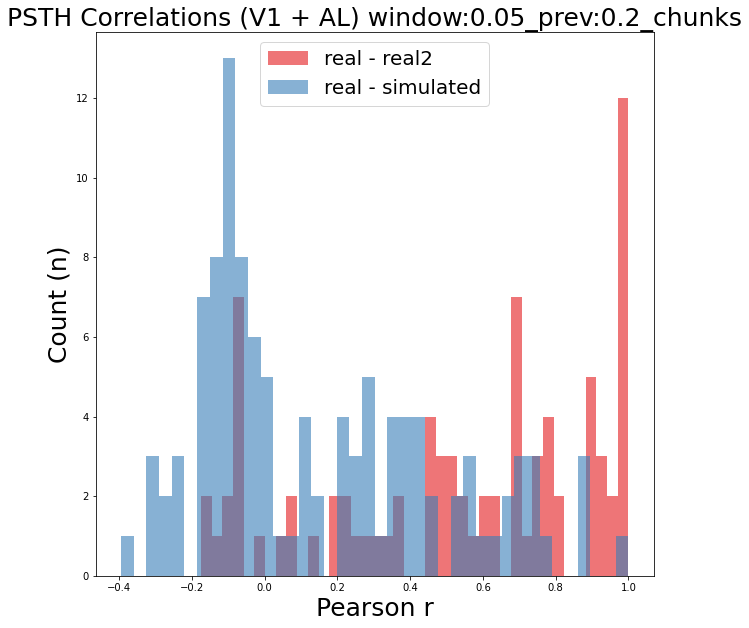

149


<Figure size 432x288 with 0 Axes>

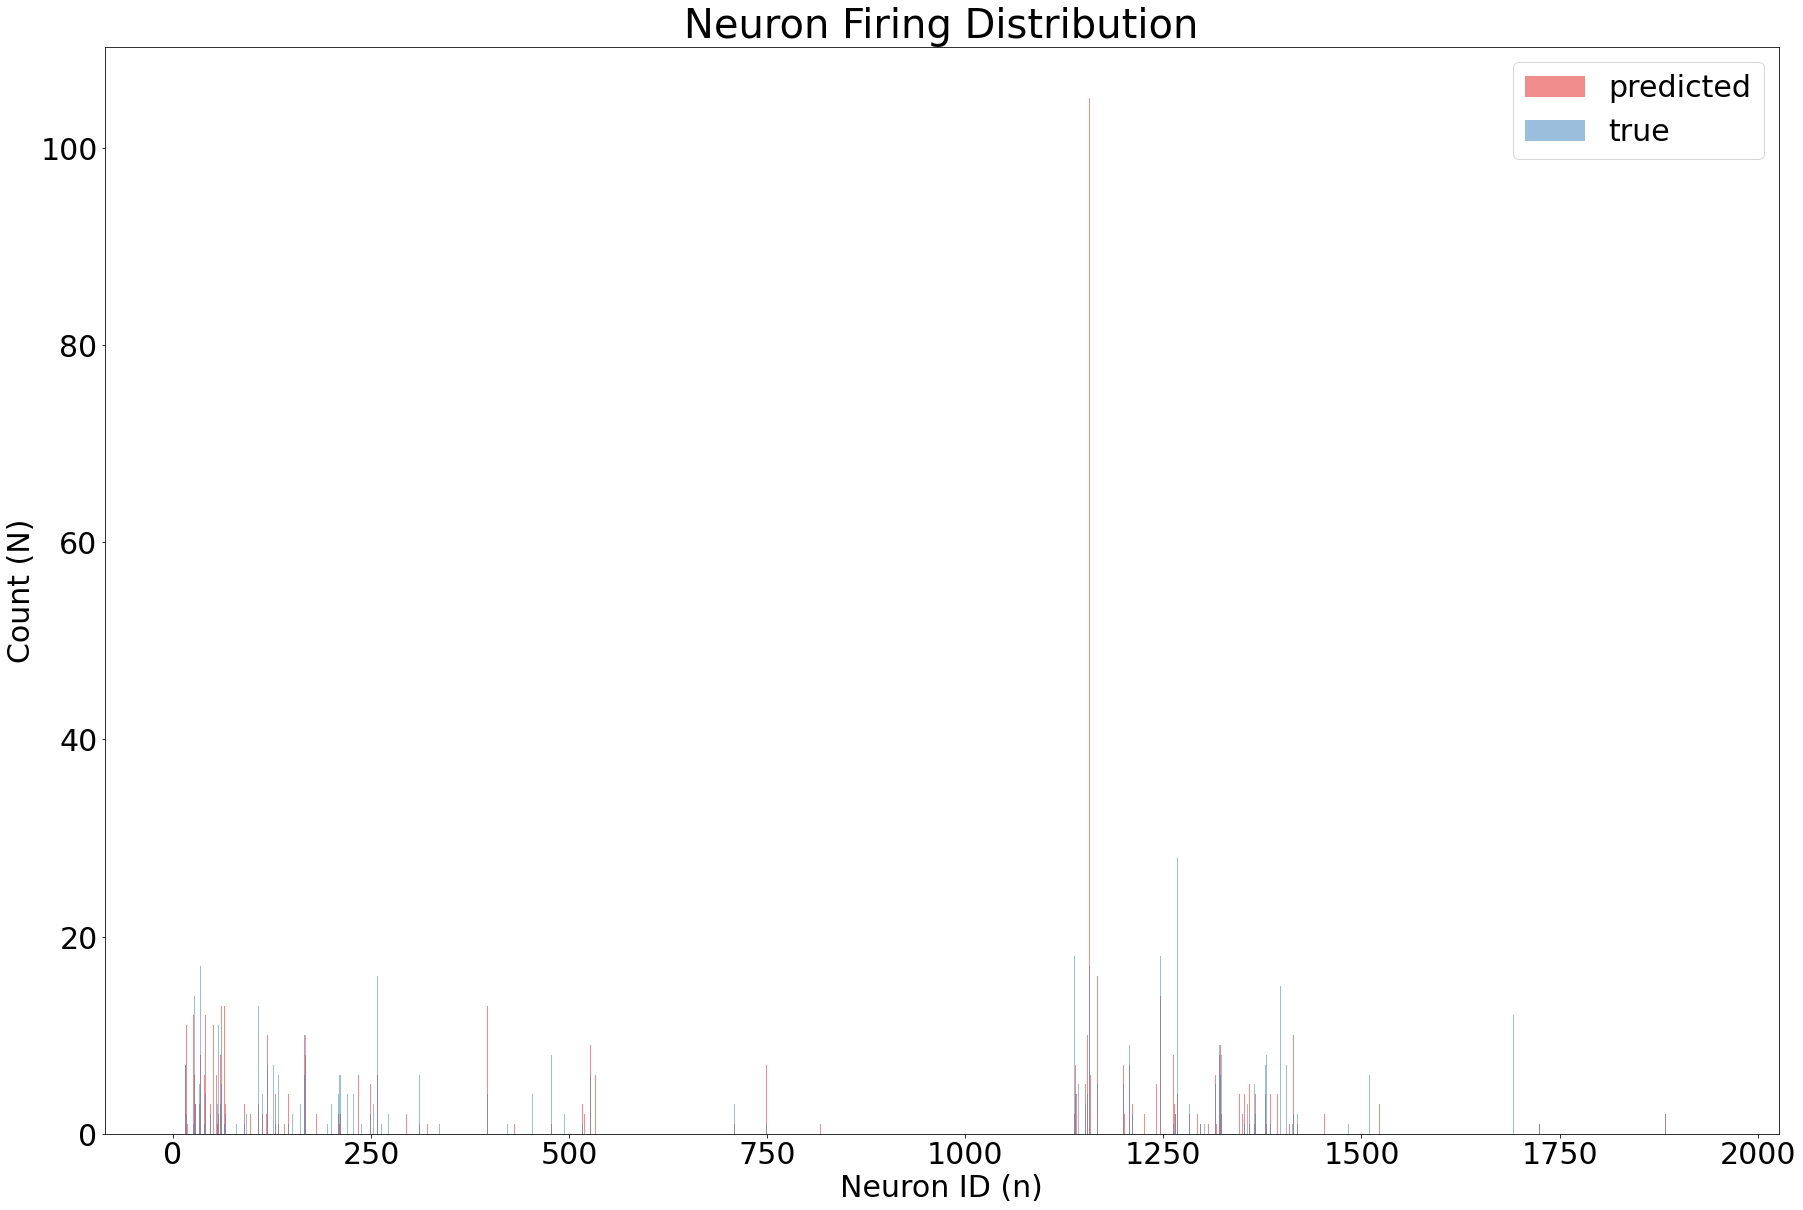

model: window:0.05_prev:0.2_chunks


In [31]:
"""

Evaluate results

"""

from visualize import *

# df_2['Trial'] -= 2
id_pred, id_true_1, id_true_2 = len(df_pred_full['ID'].unique()), len(df_1['ID'].unique()), len(df_2['ID'].unique())
print(f"id_pred: {id_pred}, id_true_1: {id_true_1}, id_true_2: {id_true_2}")

len_pred, len_true = len(df_pred_full), len(df_1)
print(f"len_pred: {len_pred}, len_true: {len_true}")

accuracy = get_accuracy(df_pred_full, df_2)

scores = compute_scores(df_1, df_2)
pred_scores = compute_scores(df_1, df_pred_full)
print(f"real: {scores}")
print(f"pred: {pred_scores}")


n_bins = 30
set_plot_white()
plt.figure(figsize=(10, 10), facecolor='white')
plt.title(f'PSTH Correlations (V1 + AL) {title}', fontsize=25)
plt.ylabel('Count (n)', fontsize=25)
plt.xlabel('Pearson r', fontsize=25)
plt.hist(top_corr_real, label='real - real2', alpha=0.6, bins=40)
# plt.hist(top_corr_real_2, label='real - real3', alpha=0.6)
plt.hist(top_corr_pred, label='real - simulated', alpha=0.6, bins=40)
plt.legend(fontsize=20)
plt.show()

dir_name = os.path.dirname(model_path)
model_name = os.path.basename(model_path)

top_p = 0
save_title = title + f'_top_p{top_p}'

plt.savefig(os.path.join(dir_name, F'psth_corr_{save_title}_.svg'))
df_pred.to_csv(os.path.join(dir_name, F'df_pred_{save_title}_.csv'))

plot_distribution(df_1, df_pred_full, save_path=os.path.join(dir_name, F'psth_dist_.svg'))

total_scores = dict()
total_scores['real'] = scores
total_scores['pred'] = pred_scores

print(f"model: {title}")
